In [1]:
# uncomment for first time running
# import sys
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install pydotplus
# import nltk
# nltk.download('punkt')

https://www.kaggle.com/luthfim/steam-reviews-dataset

The dataset is simply a csv of steam reviews for some games. I would imagine words like "bad" or phrases like "not good" indicate a "Not Recommended", and words like "good" and "great" indicate a "Recommended". Further I'd imagine that a high number of hours played would indicate a "Recommended" review.

I'd like to see how certain aspects of steam game reviews correllate with a helpful review of a game. I plan to look at how words used in the review and funny/helpful/hour counts describe the helpfulness of the review. I will train the tree model on a subset of Rust game reviews, and evaluate it on a subset of Rust reviews as well as GTA, PUBG, and Euro Truck Simulator reviews. The inclusion of the other games will affect the TFIDF calculation because it is necessary for all the test data to have the same features. They are included because I believe that positive or negative reviews for games tend to be similar, and I intend to investigate this question. I will start with a decision tree.

In [2]:
# Load modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image 
from io import StringIO
import pydotplus
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pd.set_option('display.max_rows', 500)

seed = 69

In [3]:
# Load data
df = pd.read_csv("steam_reviews.csv")
df = df[['title','recommendation','funny','helpful','hour_played','review','date_posted','is_early_access_review']]
# I'm going to drop the date and all early access
# reviews since I won't be using them in my analysis
df = df.dropna()
df = df[df.is_early_access_review == False]
df = df.drop(['date_posted','is_early_access_review'],axis = 1)

df.head()

,title,recommendation,funny,helpful,hour_played,review
0,Expansion - Hearts of Iron IV: Man the Guns,Recommended,2,4,578,&gt Played as German Reich&gt Declare war on B...
1,Expansion - Hearts of Iron IV: Man the Guns,Recommended,0,0,184,yes.
2,Expansion - Hearts of Iron IV: Man the Guns,Recommended,0,0,892,Very good game although a bit overpriced in my...
3,Dead by Daylight,Recommended,126,1086,676,Out of all the reviews I wrote This one is pro...
4,Dead by Daylight,Recommended,85,2139,612,Disclaimer I survivor main. I play games for f...


Let's do some EDA

In [4]:
# Let's see what games we have

print("Number of games: "+str(len(df.title.unique())))
print("Review counts:")
print(df.title.value_counts())

Number of games: 42
Review counts:
Grand Theft Auto V                               99677
PLAYERUNKNOWN'S BATTLEGROUNDS                    77092
Rocket League                                    67765
Dead by Daylight                                 22178
MONSTER HUNTER: WORLD                            18390
Rust                                             15536
The Elder Scrolls V: Skyrim Special Edition       1471
RESIDENT EVIL 2 / BIOHAZARD RE:2                  1384
Sid Meier’s Civilization VI                        522
Euro Truck Simulator 2                             499
Terraria                                           260
Left 4 Dead 2                                      221
Insurgency: Sandstorm                              220
Stardew Valley                                     202
Garry's Mod                                        202
Subnautica                                         198
Human: Fall Flat                                   172
ASTRONEER                     

I'll discard all games I'm not interested in comparing, and this is also due to the limitations of my computer.

In [5]:
min_reviews = 200
train_sample_size = 12000 # max per game
test_sample_size = 2000 # max per game

df = pd.merge(df,df.title.value_counts(),left_on='title',right_index=True)
df = df.drop(['title_x'],axis=1)
df = df.rename(columns = {"title_y":"review_count","funny":"funny_rating","helpful":"helpful_rating","recommendation":"recommended"})
df.recommended[df.recommended == "Recommended"] = True
df.recommended[df.recommended == "Not Recommended"] = False

# Limit analysis to because this takes too long on my computer and takes up 269 Gb
df_rust = df[df.title == 'Rust'].sample(n=train_sample_size,random_state=seed)
df_gta = df[df.title == 'Grand Theft Auto V'].sample(n=test_sample_size,random_state=seed)
df_pubg = df[df.title == 'PLAYERUNKNOWN\'S BATTLEGROUNDS'].sample(n=test_sample_size,random_state=seed)
df_ets = df[df.title == 'Euro Truck Simulator 2']
df = pd.concat([df_rust,df_gta,df_pubg,df_ets])

<ipython-input-5-f3d1c8da2d94>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.recommended[df.recommended == "Recommended"] = True
<ipython-input-5-f3d1c8da2d94>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.recommended[df.recommended == "Not Recommended"] = False


Now that all the data is tidied up, time to tokenize/stem and compute TFIDF

In [6]:
stemmer = SnowballStemmer('english')
df['tokenized_review'] = df['review'].apply(lambda review: word_tokenize(review))
df['stemmed_review'] = df['tokenized_review'].apply(lambda tokens: [stemmer.stem(token) for token in tokens])
df.stemmed_review = df.stemmed_review.apply(lambda tokens: ' '.join(tokens))

corpus = df.stemmed_review.tolist()

# load is one of the surprising ones, comes from stemming of download which is a very common word
stop_words_list = ['the','they','them','now','load','you']

vectorizer = TfidfVectorizer(strip_accents = 'ascii',ngram_range = (1,2),max_features=500,stop_words=stop_words_list)
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()
X.toarray()
TFIDF = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names(),index=df.index).add_suffix("_TFIDF")

df = pd.merge(df,TFIDF,left_index=True,right_index=True,suffixes=(False,False))
df = df.dropna()

# drop columns we aren't using in our model
df = df.drop(['review','review_count','tokenized_review','stemmed_review'],axis=1)

print(df.head())



       title recommended  funny_rating  helpful_rating  hour_played  10_TFIDF  \
425665  Rust        True             0               0          514       0.0   
427716  Rust        True             0               0          115       0.0   
429893  Rust        True             0               0           50       0.0   
400174  Rust        True             0               0          519       0.0   
428541  Rust       False             0               0         1568       0.0   

        10 10_TFIDF  10 would_TFIDF  100_TFIDF  20_TFIDF  ...  worth_TFIDF  \
425665          0.0             0.0        0.0       0.0  ...          0.0   
427716          0.0             0.0        0.0       0.0  ...          0.0   
429893          0.0             0.0        0.0       0.0  ...          0.0   
400174          0.0             0.0        0.0       0.0  ...          0.0   
428541          0.0             0.0        0.0       0.0  ...          0.0   

        would_TFIDF  would be_TFIDF  year_TF

Let's inspect our features to see if they look reasonable (which they do to me)

In [7]:
print(df[df.columns[9:]].max())

20_TFIDF                0.705918
30_TFIDF                0.737493
abl_TFIDF               0.433743
abl to_TFIDF            0.435334
about_TFIDF             0.723394
absolut_TFIDF           1.000000
access_TFIDF            0.550107
actual_TFIDF            0.626819
ad_TFIDF                0.834482
add_TFIDF               0.838806
addict_TFIDF            1.000000
after_TFIDF             0.665875
again_TFIDF             0.797505
all_TFIDF               1.000000
almost_TFIDF            0.533314
alot_TFIDF              0.810783
also_TFIDF              0.555348
alway_TFIDF             1.000000
am_TFIDF                1.000000
amaz_TFIDF              1.000000
amount_TFIDF            0.552927
amount of_TFIDF         0.561228
an_TFIDF                0.926079
and_TFIDF               1.000000
and get_TFIDF           0.522451
and have_TFIDF          0.401559
and it_TFIDF            0.642374
and then_TFIDF          0.674173
ani_TFIDF               0.738816
anoth_TFIDF             0.578546
anyon_TFID

In [8]:
df.head()

,title,recommended,funny_rating,helpful_rating,hour_played,10_TFIDF,10 10_TFIDF,10 would_TFIDF,100_TFIDF,20_TFIDF,...,worth_TFIDF,would_TFIDF,would be_TFIDF,year_TFIDF,yes_TFIDF,yoink_TFIDF,yoink trihard_TFIDF,your_TFIDF,your base_TFIDF,yourself_TFIDF
425665,Rust,True,0,0,514,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
427716,Rust,True,0,0,115,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
429893,Rust,True,0,0,50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400174,Rust,True,0,0,519,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
428541,Rust,False,0,0,1568,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now I'll prepare the data to do some ML on it

In [9]:
grouped = df.groupby('title')
ml_df = grouped.get_group('Rust')

# we're using all the features
feature_cols = ml_df.columns[2:].to_list()

X = ml_df[feature_cols]
y = ml_df.recommended.to_list()

# split the data into a training and testing set
train_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=seed)

Now we start building our tree classifier maximizing information gain

~~~ depth = 1 ~~~
Rust accuracy is 0.77375
Euro Truck Simulator 2 weighted accuracy is 0.7212121212121212
Grand Theft Auto V weighted accuracy is 0.597979797979798
PLAYERUNKNOWN'S BATTLEGROUNDS weighted accuracy is 0.49242424242424243
~~~ depth = 2 ~~~
Rust accuracy is 0.77875
Euro Truck Simulator 2 weighted accuracy is 0.9878787878787879
Grand Theft Auto V weighted accuracy is 0.6
PLAYERUNKNOWN'S BATTLEGROUNDS weighted accuracy is 0.4686868686868687
~~~ depth = 3 ~~~
Rust accuracy is 0.7804166666666666
Euro Truck Simulator 2 weighted accuracy is 0.7353535353535353
Grand Theft Auto V weighted accuracy is 0.602020202020202
PLAYERUNKNOWN'S BATTLEGROUNDS weighted accuracy is 0.49747474747474746
~~~ depth = 4 ~~~
Rust accuracy is 0.7866666666666666
Euro Truck Simulator 2 weighted accuracy is 0.9656565656565657
Grand Theft Auto V weighted accuracy is 0.6146464646464647
PLAYERUNKNOWN'S BATTLEGROUNDS weighted accuracy is 0.48383838383838385
~~~ depth = 5 ~~~
Rust accuracy is 0.7875
Euro Truck

Text(0.5, 1.0, 'avg weighted accuracy vs depth for entropy model')

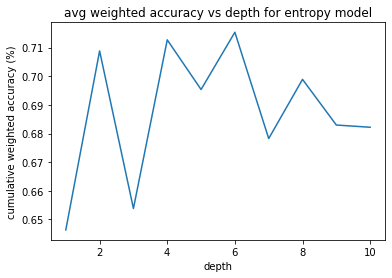

In [10]:
num_depths = 10
cum_accuracy = [0]*num_depths
depths = np.arange(1,num_depths+1)

test_games = ['Euro Truck Simulator 2',
 'Grand Theft Auto V','PLAYERUNKNOWN\'S BATTLEGROUNDS']

# for each depth, compute the accuracy of the model against the Rust testing set
# and store it for later analysis
for depth in depths :
    tree_model = DecisionTreeClassifier(criterion='entropy',max_depth=depth)
    tree_model = tree_model.fit(X_train,y_train)
    
    y_pred = tree_model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    cum_accuracy[depth-1] += accuracy

    print("~~~ depth = "+str(depth)+" ~~~")
    print("Rust accuracy is "+str(accuracy))
    
    for ml_df in [grouped.get_group(game) for game in test_games] :
        game = str(ml_df.title.unique()[0])
        # we're using all the features
        feature_cols = ml_df.columns[2:].to_list()

        X_game = ml_df[feature_cols]
        y_game = ml_df.recommended.to_list()
        garb, X_test_game, garb, y_test_game = train_test_split(X_game, y_game, test_size=.99, random_state=seed)

        y_pred_game = tree_model.predict(X_test_game)

        accuracy = metrics.accuracy_score(y_test_game, y_pred_game)
        cum_accuracy[depth-1] += accuracy
        print(game+" weighted accuracy is "+str(accuracy))

# plot the average accuracy as a function of tree depth
fig = plt.figure()
plt.plot(depths,[quotient/len(grouped.groups) for quotient in cum_accuracy])
plt.xlabel("depth")
plt.ylabel("cumulative weighted accuracy (%)")
plt.title("avg weighted accuracy vs depth for entropy model")

Here we do the same exact steps but minimizing Gini impurity

~~~ depth = 1 ~~~
Rust accuracy is 0.7779166666666667
Euro Truck Simulator 2 weighted accuracy is 0.7636363636363637
Grand Theft Auto V weighted accuracy is 0.5954545454545455
PLAYERUNKNOWN'S BATTLEGROUNDS weighted accuracy is 0.4868686868686869
~~~ depth = 2 ~~~
Rust accuracy is 0.7779166666666667
Euro Truck Simulator 2 weighted accuracy is 0.7636363636363637
Grand Theft Auto V weighted accuracy is 0.5954545454545455
PLAYERUNKNOWN'S BATTLEGROUNDS weighted accuracy is 0.4868686868686869
~~~ depth = 3 ~~~
Rust accuracy is 0.7866666666666666
Euro Truck Simulator 2 weighted accuracy is 0.9696969696969697
Grand Theft Auto V weighted accuracy is 0.6060606060606061
PLAYERUNKNOWN'S BATTLEGROUNDS weighted accuracy is 0.4782828282828283
~~~ depth = 4 ~~~
Rust accuracy is 0.7854166666666667
Euro Truck Simulator 2 weighted accuracy is 0.9171717171717172
Grand Theft Auto V weighted accuracy is 0.6383838383838384
PLAYERUNKNOWN'S BATTLEGROUNDS weighted accuracy is 0.5181818181818182
~~~ depth = 5 ~~

Text(0.5, 1.0, 'avg weighted accuracy vs depth for gini model')

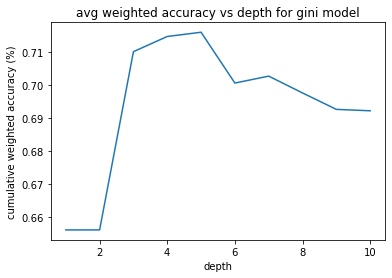

In [11]:
num_depths = 10
cum_accuracy = [0]*num_depths
depths = np.arange(1,num_depths+1)

test_games = ['Euro Truck Simulator 2',
 'Grand Theft Auto V','PLAYERUNKNOWN\'S BATTLEGROUNDS']

for depth in depths :
    tree_model = DecisionTreeClassifier(criterion='gini',max_depth=depth)
    tree_model = tree_model.fit(X_train,y_train)
    
    y_pred = tree_model.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    cum_accuracy[depth-1] += accuracy

    print("~~~ depth = "+str(depth)+" ~~~")
    print("Rust accuracy is "+str(accuracy))
    
    for ml_df in [grouped.get_group(game) for game in test_games] :
        game = str(ml_df.title.unique()[0])
        # we're using all the features
        feature_cols = ml_df.columns[2:].to_list()

        X_game = ml_df[feature_cols]
        y_game = ml_df.recommended.to_list()
        garb, X_test_game, garb, y_test_game = train_test_split(X_game, y_game, test_size=.99, random_state=seed)

        y_pred_game = tree_model.predict(X_test_game)

        accuracy = metrics.accuracy_score(y_test_game, y_pred_game)
        cum_accuracy[depth-1] += accuracy
        print(game+" weighted accuracy is "+str(accuracy))

# plot the average accuracy as a function of tree depth
fig = plt.figure()
plt.plot(depths,[quotient/len(grouped.groups) for quotient in cum_accuracy])
plt.xlabel("depth")
plt.ylabel("cumulative weighted accuracy (%)")
plt.title("avg weighted accuracy vs depth for gini model")

We see that the trees seems to have good generalization accuracy at a reasonable depth at depth = 4, let's see what the trees are actually doing

Entropy Decision Tree

In [12]:
grouped = df.groupby('title')
ml_df = grouped.get_group('Rust')

# we're using all the features
feature_cols = ml_df.columns[2:].to_list()

X = ml_df[feature_cols]
y = ml_df.recommended.to_list()

# split the data into a training and testing set
train_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=seed)

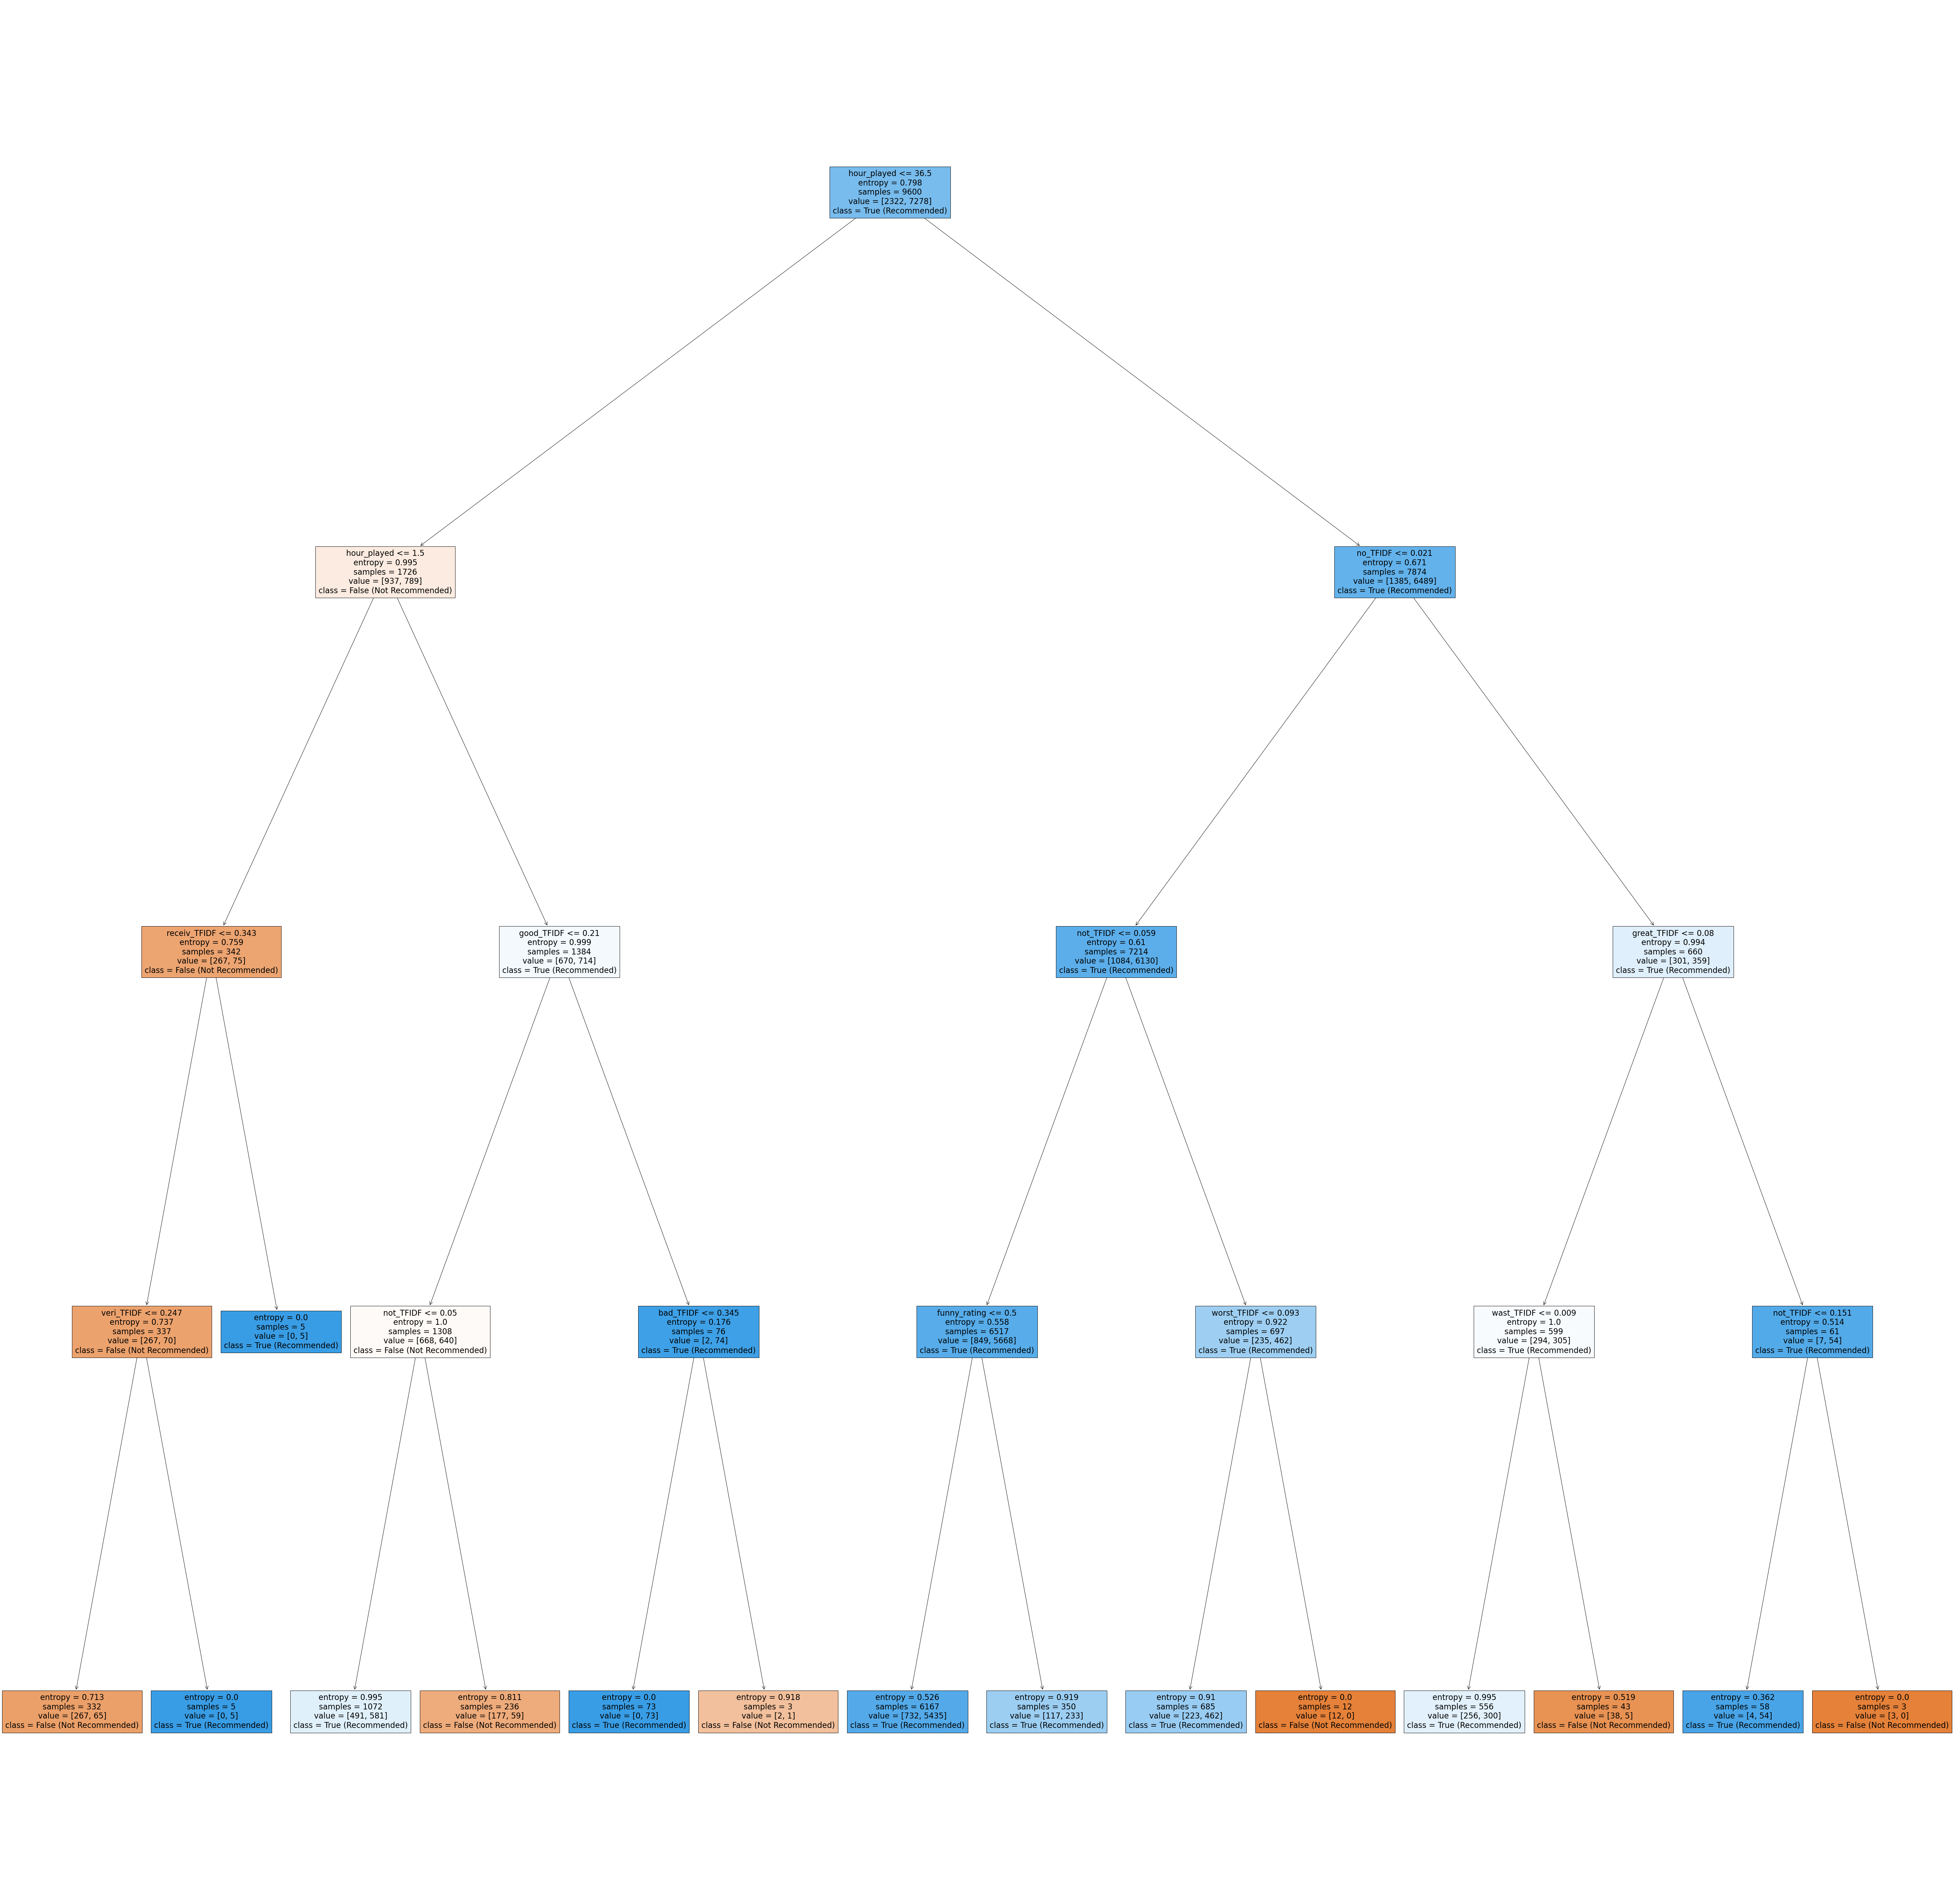

In [13]:
tree_model = DecisionTreeClassifier(criterion='entropy',max_depth=4)
tree_model = tree_model.fit(X_train,y_train)

fig = plt.figure(figsize=(100,100))
_ = tree.plot_tree(tree_model, feature_names = X.columns.to_list(),
                   class_names=["False (Not Recommended)","True (Recommended)"],filled=True)

Gini Decision Tree

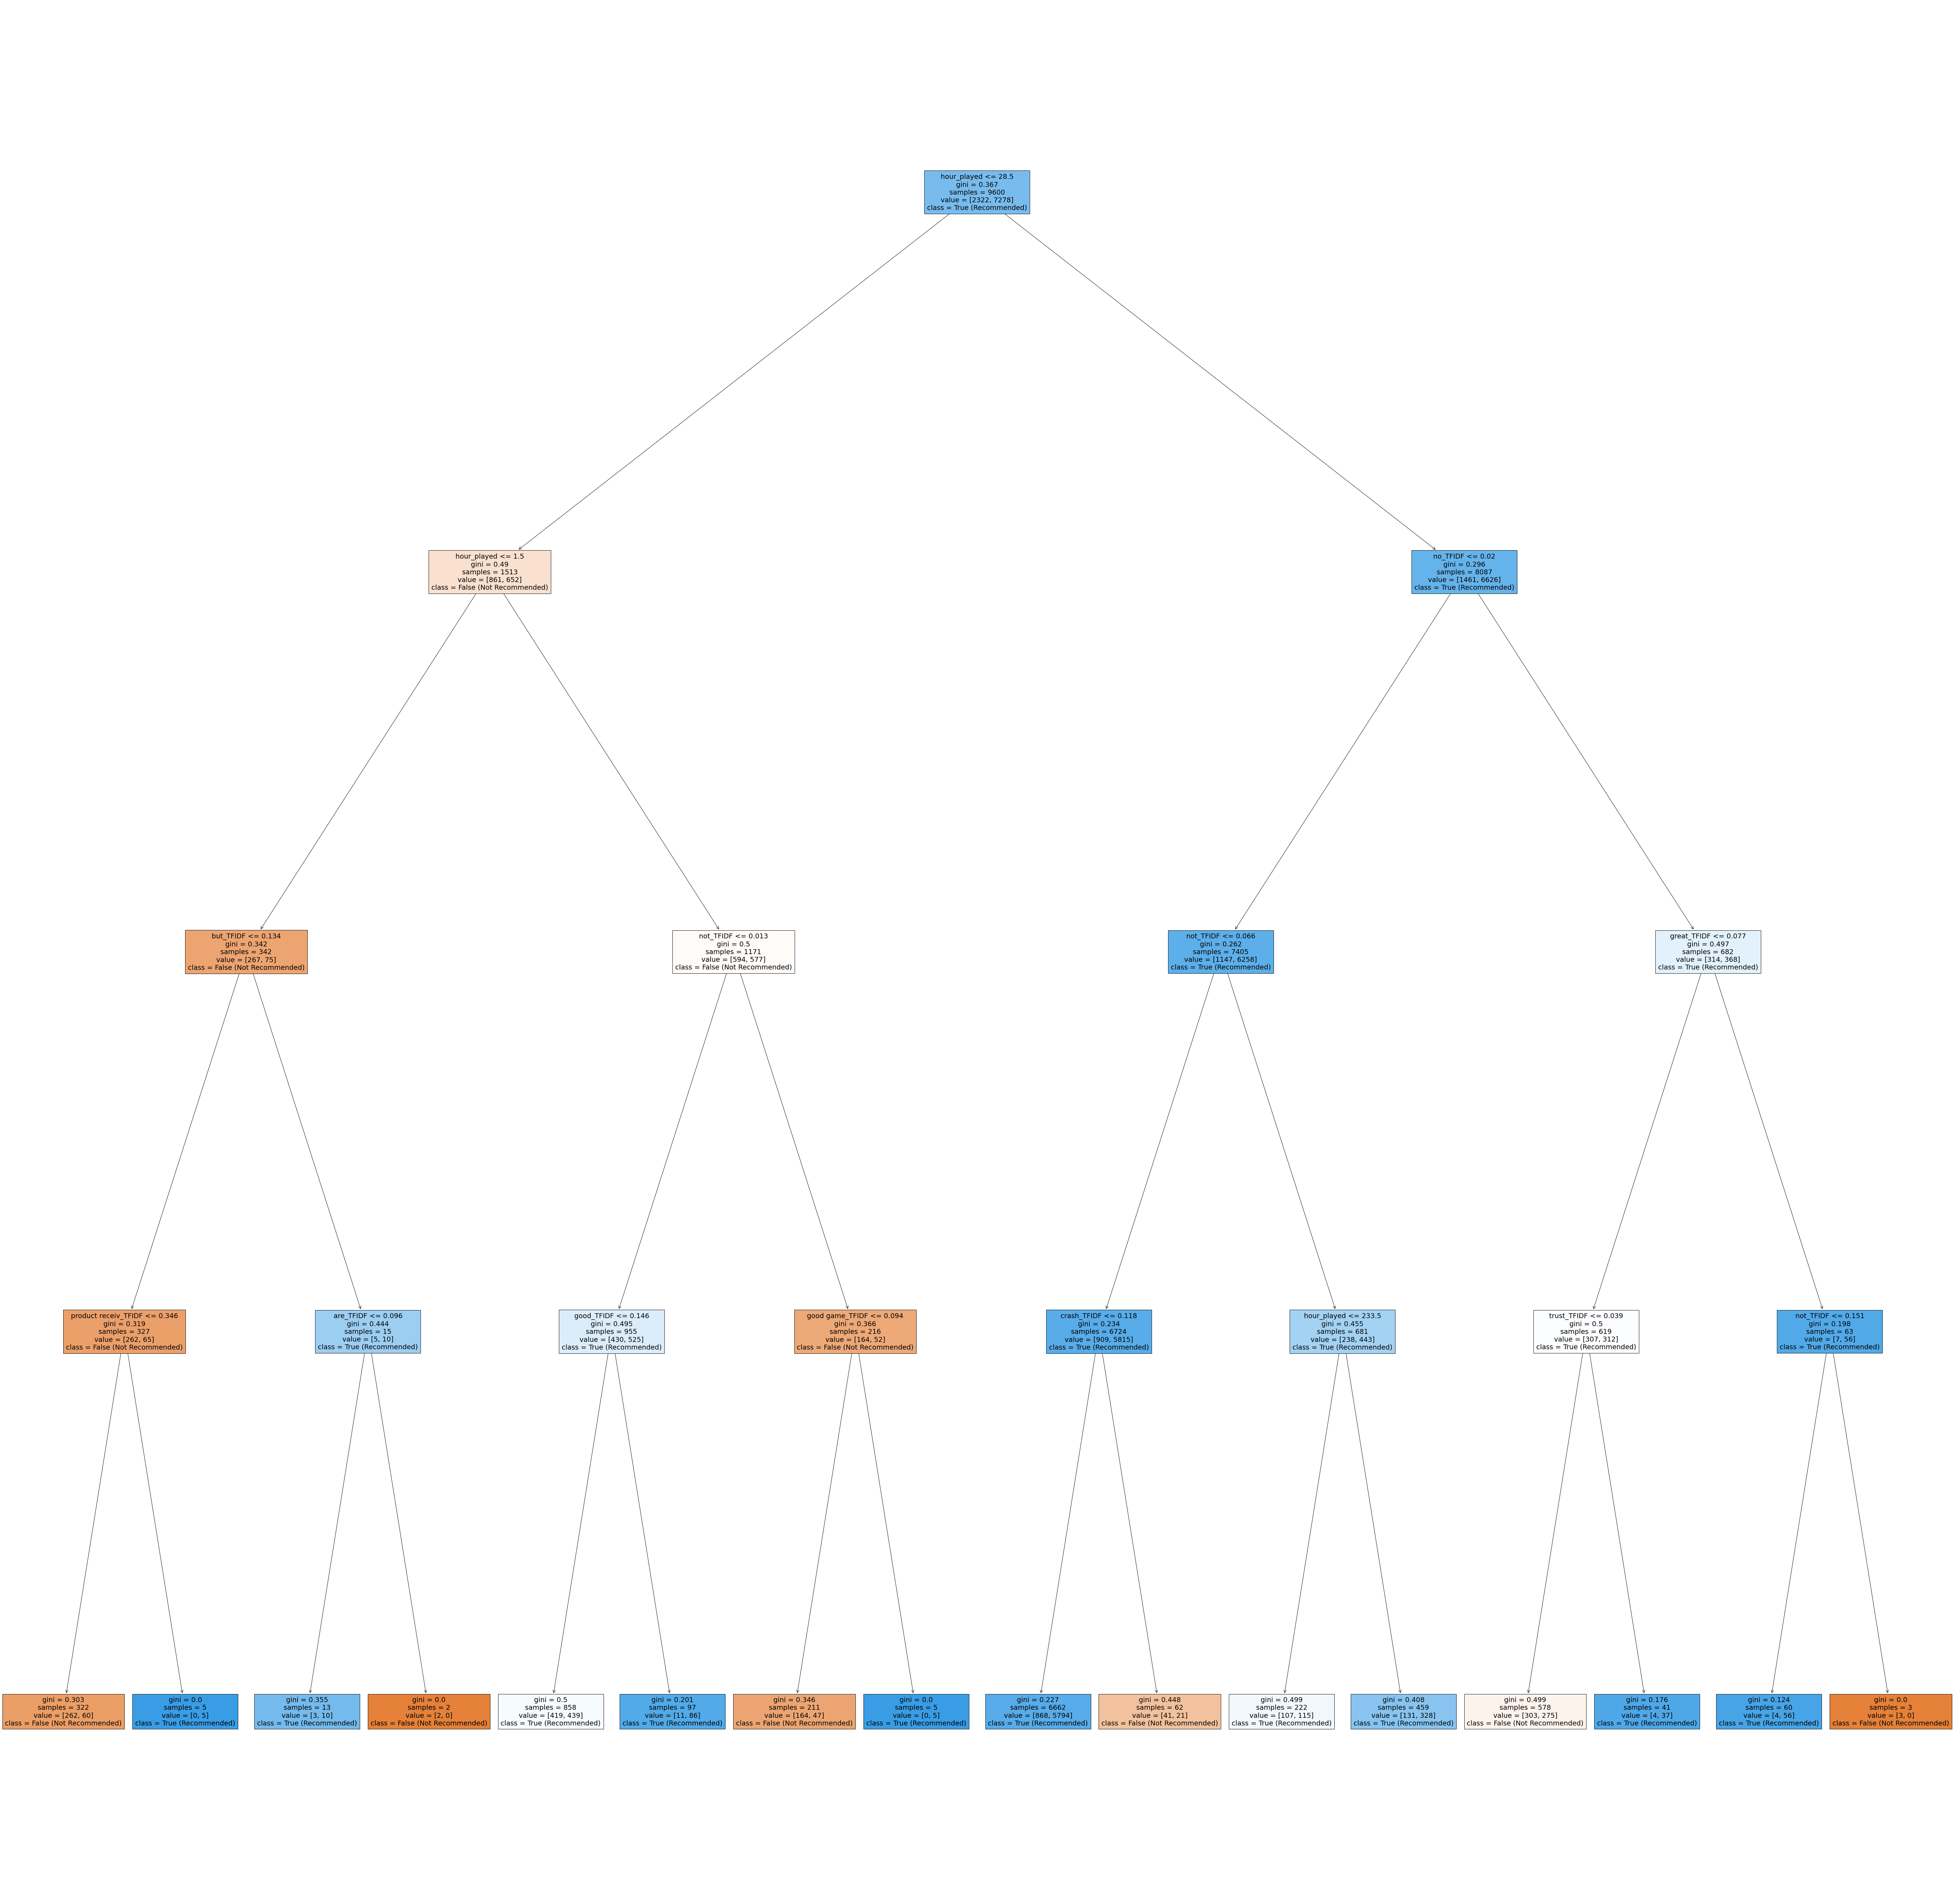

In [14]:
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=4)
tree_model = tree_model.fit(X_train,y_train)

fig = plt.figure(figsize=(100,100))
_ = tree.plot_tree(tree_model, feature_names = X.columns.to_list(),
                   class_names=["False (Not Recommended)","True (Recommended)"],filled=True)

After messing with a range of hyperparameters (stop words, split depth, split criterion, etc.), and comparing the graphs qualitatively, it's time to look at the numbers.

In [15]:
# entropy
tree_model = DecisionTreeClassifier(criterion='entropy',max_depth=depth)
tree_model = tree_model.fit(X_train,y_train)

y_pred = tree_model.predict(X_test)

print("Entropy model:")
print(metrics.classification_report(y_test, y_pred))

# gini
tree_model = DecisionTreeClassifier(criterion='gini',max_depth=depth)
tree_model = tree_model.fit(X_train,y_train)

y_pred = tree_model.predict(X_test)

print("Gini model:")
print(metrics.classification_report(y_test, y_pred))

Entropy model:
              precision    recall  f1-score   support

       False       0.64      0.36      0.46       599
        True       0.81      0.93      0.87      1801

    accuracy                           0.79      2400
   macro avg       0.73      0.65      0.66      2400
weighted avg       0.77      0.79      0.77      2400

Gini model:
              precision    recall  f1-score   support

       False       0.67      0.42      0.51       599
        True       0.83      0.93      0.88      1801

    accuracy                           0.80      2400
   macro avg       0.75      0.67      0.70      2400
weighted avg       0.79      0.80      0.79      2400



You can see that the Gini tree slightly outperforms the entropy tree, and it's decision tree seems to be slightly closer to reality as well, so I would choose the Gini tree as my final model.

Now we will analyze the same data set using LDA. Much of the work is already done for us, so we will leverage that.

In [16]:
X_train_arr = X_train.to_numpy()
y_train_arr = np.asarray(y_train)
X_test_arr = X_test.to_numpy()
y_test_arr = np.asarray(y_test)

lda_model = LinearDiscriminantAnalysis()
lda_model = lda_model.fit(X_train_arr,y_train_arr)

y_pred_arr = lda_model.predict(X_test_arr)

In [17]:
print("LDA Rust Metrics:")
print(metrics.classification_report(y_test_arr, y_pred_arr))

LDA Rust Metrics:
              precision    recall  f1-score   support

       False       0.72      0.57      0.64       599
        True       0.87      0.93      0.90      1801

    accuracy                           0.84      2400
   macro avg       0.79      0.75      0.77      2400
weighted avg       0.83      0.84      0.83      2400



In [29]:
for ml_df in [grouped.get_group(game) for game in test_games] :
    print(len(ml_df))
    game = str(ml_df.title.unique()[0])
    
    feature_cols = ml_df.columns[2:].to_list()

    X_game_arr = ml_df[feature_cols].to_numpy()
    y_game_arr = np.asarray(ml_df.recommended.to_list())
    garb, X_test_game_arr, garb, y_test_game_arr = train_test_split(X_game_arr, y_game_arr, test_size=.99, random_state=seed)

    y_pred_game_arr = lda_model.predict(X_test_game_arr)
    
    print("LDA "+game+" Metrics:")
    print(metrics.classification_report(y_test_game_arr, y_pred_game_arr))

499
LDA Euro Truck Simulator 2 Metrics:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.97      0.99       495

    accuracy                           0.97       495
   macro avg       0.50      0.49      0.49       495
weighted avg       1.00      0.97      0.99       495

2000
LDA Grand Theft Auto V Metrics:
              precision    recall  f1-score   support

       False       0.71      0.50      0.59       794
        True       0.72      0.86      0.78      1186

    accuracy                           0.72      1980
   macro avg       0.71      0.68      0.69      1980
weighted avg       0.72      0.72      0.71      1980

2000
LDA PLAYERUNKNOWN'S BATTLEGROUNDS Metrics:
              precision    recall  f1-score   support

       False       0.82      0.61      0.70      1065
        True       0.65      0.84      0.73       915

    accuracy                           0.72      1980
   

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Although the LDA performs better on the training set, the decision tree seems to generalize better to other games. Note that Euro Truck Simulator 2 has all positive reviews, and on Steam's website, the user reviews are described as "Overwhelmingly positive". Both models were very good at classifying all the positive reviews correctly, suggesting that the reviews were exceptionally positive in their wording which is an interesting note IMO.